# pRFtime: a python toolbox for spatiotemporal forward modeling of brain signals

This notebook walks you through the full pipelie of the **pRFtime** framework - a biologically-inspired forward model for mapping spatio-temporal brain responses, using population receptive fields (pRFs).  

This tutorial is designed yo be *modular, readable, and reproducible*, allowing you to adapt individual steps as needed fo your own data or research question. Here we exemplify the pipeline using data from [*Eickhoff et al. (2025), bioRxiv*](https://www.biorxiv.org/content/10.1101/2025.05.12.653426v1), in which we mapping the individual contributions of visual field maps to evoked visual responses. 

**What this notebook does:**  
It walk you through the two major steps of the pipeline:   
1. Construct pRF-predictions at the sensor-level (using the `pRFs` class)  
2. Fit the sensor-level predictions to the measured sensor-level data (using the `Fitting` class).    

Each step contains a *flow diagram* illustrating the the input/output variables, how the functions are *instantiated*, and *visualizations* of the input and output. For a detailed description of the individual steps, please see: *Eickhoff et al. (2025), bioRxiv*

**Data required for the pipeline:** (examples of the data are should be downloaded from OSF [here](https://osf.io/hnw5d/), and put into the `test/example_data` folder. Alternatively, this could be substituted with your own data with the correct dimensions.)
- **pRF parameters**: pRF parameters estimated on the cortical surface, for example using the standard pRF mapping procedure described in *Dumoulin & Wandell (2008), Neuroimage*
    > * *variable name*: `prf_parameters`   
    > * *dimensions*: np.ndarray `(vertices, parameters)`, where vertices are the cortical locations on the surface, and the parameters depend on the pRF model you want to create.     
        >> The pRF parameters are used by a model class to reconstruct the models (which should be defined in the `utils.py` script). In the example here, the predefined `GaussianModel` requires three parameters: `x0`, `y0` for each pRFs position and `sigma` for it's size, defined in visual space coordinates. The pRFs are constructed on a grid (defined by `nr_pix`), with coordinates in degrees of visual angle, defined by the maximum eccentricity (`max_ecc`) the pRFs were originally measured in. The (`nr_pix`,`nr_pix`) grid should be the same the dimensions of the design matrix.  
        >> Other model classes could be freely added by the user. The class should have the functions `.generate()` and `.predict()` and the attribute `name`; see `utils.GaussianModel` for an example. 
- **Sensor data**: Sensor data, for example collected with MEG, as described in *Eickhoff et al. (2024), Imaging Neuroscience*, containing the individual responses collected to the stimuli described in the design matix. 
    > * *variable name*: `sensor_data`  
    > * *dimensions*: list with np.ndarray `[stimuli,](sensors, trials per stimulus, samples)`. The trials per stimulus is allowed to vary, for example due to preprocessing removing some trials. 
        >> For the example dataset (taken from *Eickhoff et al. (2024), Imaging Neuroscience*), 306 sensors recorded 18 stimuli. Each trial was cut to 0 to 300 ms after stimulus onset, and each trial was baseline corrected. The data was recorded with 1000Hz, and the samples (300 in total here) thus recorded each millisecond of the evoked responses. 
- **Design matrix**: Stimulus set described in a design matrix to create predicted repsonses.
    > * *variable name*: `design_matrix`
    > * *dimensions*: for example np.ndarray `(nr_pix, nr_pix, stimuli)`. 
        >> In this example set, the stimuli were visual stimuli presented in 2D space, but in principle this does not have to be the case. 
- **Gain matrix**: The gain matrix, also called leadfield matrix or forward model, calculated from a head model (see e.g. https://neuroimage.usc.edu/brainstorm/Tutorials/HeadModel). 
    > * *variable name*: `gain_matrix` 
    > * *dimensions*: np.ndarray `(sensors, vertices)`
        >> In this example we used gain matrix values calculated based on the Overlapping Spheres model (*Huang et al. (1999), Physics in Medicine & Biology*) to translate the cortex space to MEG sensor space. We constrained the dipole orientations perpendicular to the surface, giving us an estimate of how much each cortical location (vertex) contributes to the signal measured at each MEG sensor.  
- **ROI masks**: Regions of interest (ROIs) on the cortical surface for the analysis. Predictions will be created for each region, to test the contributions of the areas to the measured responses with high temporal resolution. 
    > * *variable name*: `roi_masks` 
    > * *dimensions*: boolean np.ndarray `(rois, vertices)`
        >> In this example we defined ten visual field maps we want to investigate the timing of: V1-4, LO, VO, TO, posterior anterior IPS. 




# Load data from test example 

In [1]:
# --- Load packages ---
%reload_ext autoreload
%autoreload 2

import os 
opj = os.path.join
import numpy as np
import math 

# for plotting
import matplotlib.pyplot as plt 
import seaborn as sns 
import networkx as nx

# pRFtime tools 
from pRFtime.core import pRFs
from pRFtime.utils import GaussianModel
from pRFtime.core import Fitting
import pRFtime.figures as visualize

## Load test data into notebook 

1) Dowdload test data from https://osf.io/hnw5d/, if not done already and store the files in the directory: `pRFtime/test/example_data`. 
2) Load data by running cell below.

In [2]:
# --- Test folder --- 
cur_path = os.getcwd() 
test_folder = opj(cur_path,'test','example_data') 
assert os.path.exists(test_folder), f"Please go to https://osf.io/hnw5d/ and download the files into the directory: {test_folder}"
# os.system(f"ls {test_folder}")

# --- Load Test data --- 
prf_parameters = np.load(opj(test_folder,"example_prf_parameters.npy"))
sensor_data = np.load(opj(test_folder,"example_sensor_data.npy"), allow_pickle=True) # list of arrays allows individual trial numbers per stimuli
design_matrix = np.load(opj(test_folder,"example_design_matrix.npy"))
gain_matrix = np.load(opj(test_folder,"example_gain_matrix.npy"))
roi_masks = np.load(opj(test_folder,"example_roi_masks.npy"))
# Optional analysis mask (to exclude vertices from fitting, e.g. non-visual ones here)
mask = np.load(opj(test_folder,"example_mask.npy"))
# Preset indices for trial averaging for repeatability 
n_set_inds_per_stim = np.load(opj(test_folder,"example_n_set_inds_per_stim.npy"), allow_pickle=True)

# Some info on dimensions 
nr_pix,_,nr_stimuli = design_matrix.shape
nr_sensors, nr_vertices = gain_matrix.shape 
assert gain_matrix.shape[-1] == prf_parameters.shape[0],\
    f"Number vertices of prf parameters and gain matrix must be the same."

# Print some info 
print(f"Data shapes:\n------------")
print(f"FULL PARAMS:    {prf_parameters.shape} --> (vertices x parameters)")
print(f"DESIGN MATRIX:  {design_matrix.shape} --> (pix x pix x stimuli)") 
print(f"GAIN MATRIX:     {gain_matrix.shape} --> (sensors x vertices)")
print(f"ROI MASKS:      {roi_masks.shape} --> (rois x vertices)")

print(f"\n(unmasked-) ROIs: contain {[str(roi_masks[r,:].sum()) for r in range(roi_masks.shape[0])]} vertices, respectively")
print(f"MASK: using ({mask.sum()},) from {mask.shape} vertices.")

print(f"\nDATA:    {len(sensor_data)} stimuli in dataset, example stimulus data shape: {sensor_data[0].shape} --> (sensors x trials x time)")
nr_trials_per_stim = [sensor_data[s].shape[1] for s in range(len(sensor_data))]
print(f"        average number trials across stimuli: {np.mean(nr_trials_per_stim):.2f} with range: [{np.min(nr_trials_per_stim)}-{np.max(nr_trials_per_stim)}]")

Data shapes:
------------
FULL PARAMS:    (617224, 3) --> (vertices x parameters)
DESIGN MATRIX:  (101, 101, 18) --> (pix x pix x stimuli)
GAIN MATRIX:     (306, 617224) --> (sensors x vertices)
ROI MASKS:      (10, 617224) --> (rois x vertices)

(unmasked-) ROIs: contain ['4288', '4451', '5320', '4549', '2027', '4962', '3819', '4998', '4306', '15219'] vertices, respectively
MASK: using (63160,) from (617224,) vertices.

DATA:    18 stimuli in dataset, example stimulus data shape: (306, 160, 300) --> (sensors x trials x time)
        average number trials across stimuli: 161.39 with range: [160-162]


# Step 1: Create sensor-level pRF predictions 

**In this step, we need:** 

*For pRF model creation:* estimated pRF parameters, optional mask to exclude vertices    
*For pRF predictions:* design matrix, ROI masks     
*For conversion to sensor space:* gain matrix

**Overview output** - the class `pRFs`: 
- creates the pRF models based on the given parameters using the provided or  self-specified `model_class.generate()` function
    > *output*: `pRFs.prf_dict['prfs']` of shape `(vertices, pix, pix)`
- creates pRF predictions to the given stimuli in the design matrix using the specified `model_class.predict()` function
    > *output:* `pRFs.cortex_predictions` of shape `(vertices, stimuli)`
- converts the pRF predictions to sensor-space, for the given ROI's, using the gain matrix weights provided
    > *output:* `pRFs.sensor_predictions` of shape `(rois, sensors, stimuli)`


## Schematic overview

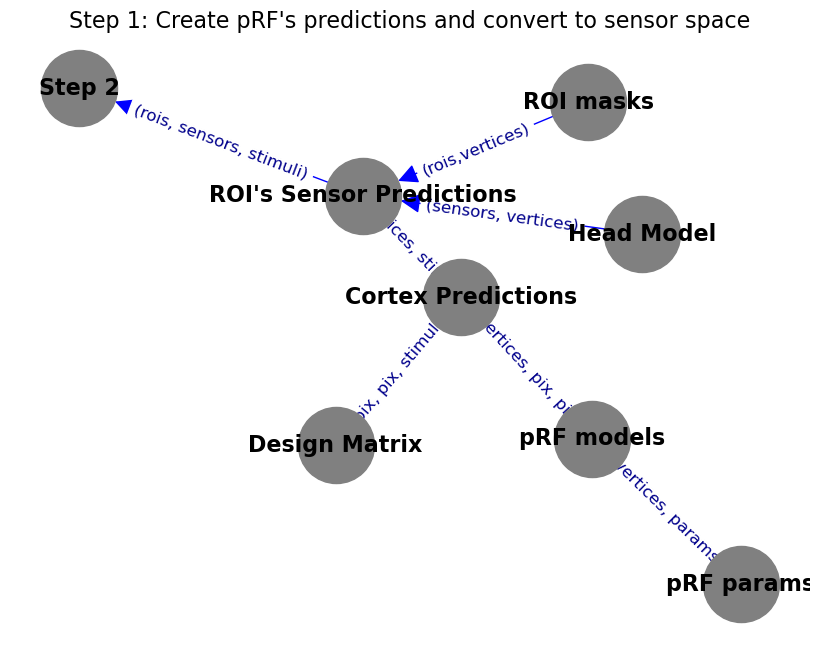

In [28]:
fig_flow1 = visualize.flow_chart_step_1()

## Perform step 1 

In [ ]:
# Input settings from example dataset 
nr_pix = 101 # number of pixels (width and height) that defines the grid of the visual space in which both the pRFs and stimulus live in
max_ecc = 5.34 # in degrees of visual angle (dva) determining the boundaries of visual space 
verbose = True 

# Instantiate class for model and prediction creation 
prf = pRFs(prf_parameters = prf_parameters, 
           model_class = GaussianModel, # preset model class - can be substituted by other added classes in utils.py
           model_kwargs = {'nr_pix': nr_pix, 'max_ecc': max_ecc},# arguments the model class needs for generating the model and create the predictions
           mask = mask, # optional mask 
           verbose = verbose)

prf.create_sensor_predictions(gain_matrix=gain_matrix, 
                              design_matrix=design_matrix,
                              roi_masks=roi_masks) 
# main output: 
# .sensor_predictions (rois, sensors, stimuli)

===== `create_prf_models` =====
(Mask) Using 63160 of 617224 vertices...
Creating 63160 pRF models using 'Gaussian' model...
Done.
|--> .prf_dict['prfs'] = (63160, 101, 101) = ((masked-)vertices, pix, pix)
===== `create_cortex_predictions` =====
Creating 'Gaussian' cortex predictions...
Done.
|--> .cortex_predictions = (617224, 18) = (vertices, stimuli)
===== `create_sensor_predictions` =====
Creating 10-roi sensor predictions...
(Mask:) roi-0 is using 2904 of originally 4288  vertices...
(Mask:) roi-1 is using 3008 of originally 4451  vertices...
(Mask:) roi-2 is using 3309 of originally 5320  vertices...
(Mask:) roi-3 is using 2345 of originally 4549  vertices...
(Mask:) roi-4 is using 1116 of originally 2027  vertices...
(Mask:) roi-5 is using 4289 of originally 4962  vertices...
(Mask:) roi-6 is using 1438 of originally 3819  vertices...
(Mask:) roi-7 is using 3303 of originally 4998  vertices...
(Mask:) roi-8 is using 1636 of originally 4306  vertices...
(Mask:) roi-9 is using 108

## Visualize

### *Visualize design matrix and an example pRF*

We used 18 stimuli (10 bars and 8 circles), that we binarized to create predictions.  
Both our stimuli and pRFs models live in 2D visual space. They are constructed on a grid (determined by `nr_pix`) and the coordinates are in degrees of visual angle (limited by the maximum eccentricity the stimuli were presented at, here `max_ecc`). 

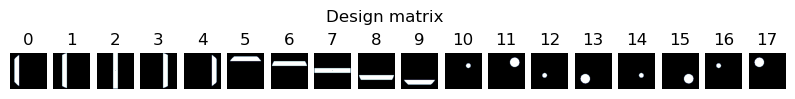

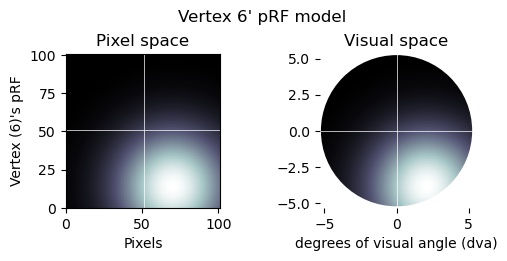

In [48]:
fig_dm = visualize.stimulus_design_matrix(design_matrix)
fig_prf = visualize.prf_in_space(prfs = prf.prf_dict['prfs'], vertex = 6)

### *Visualize example **cortex** (pRF's) predictions created*

For the 2D Gaussian model we used, the predictions are the result of a matrix multiplication of the stimuli with the pRF (upper row figure below). The resulting predicted value is thus high when the pRF overlaps with the presented stimulus (bottom row figure below).

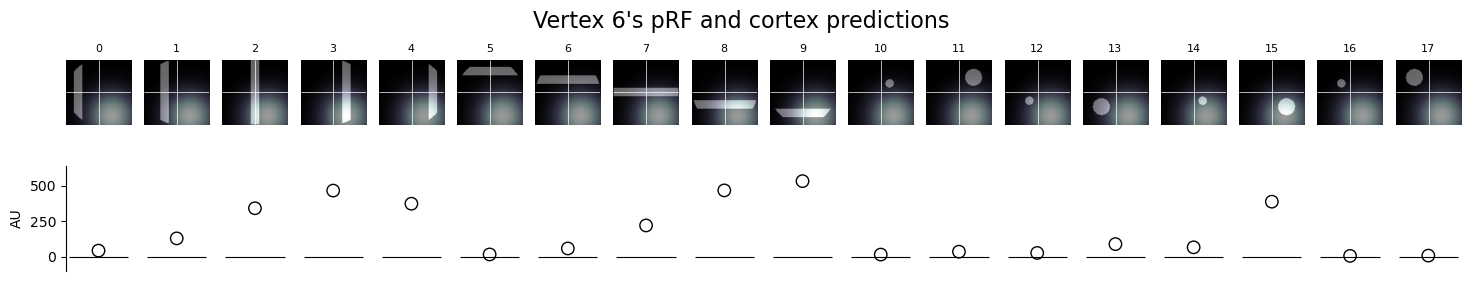

In [52]:
fig_prfpreds = visualize.cortex_preds(prfs = prf.prf_dict['prfs'], 
                                      cortex_predictions = prf.cortex_predictions, 
                                      design_matrix = design_matrix, 
                                      vertex = 6)

### *Visualize example **sensors** predictions created*

Although for the fitting procedure all sensors and stimuli are used in a concatenated manner inside the ridge regression, we can look at individual sensors predictions.   
The units now are in the same space as the gain matrix values are in (here femto Tesla), and can therefore also be sigend (as the weights in the gain matrix).  
As we restricted the sensor predictions to come from individual ROIs (so only parts of the cortex), we can look at how the predicted responses from each of the ROI's would look like for a given sensor. 

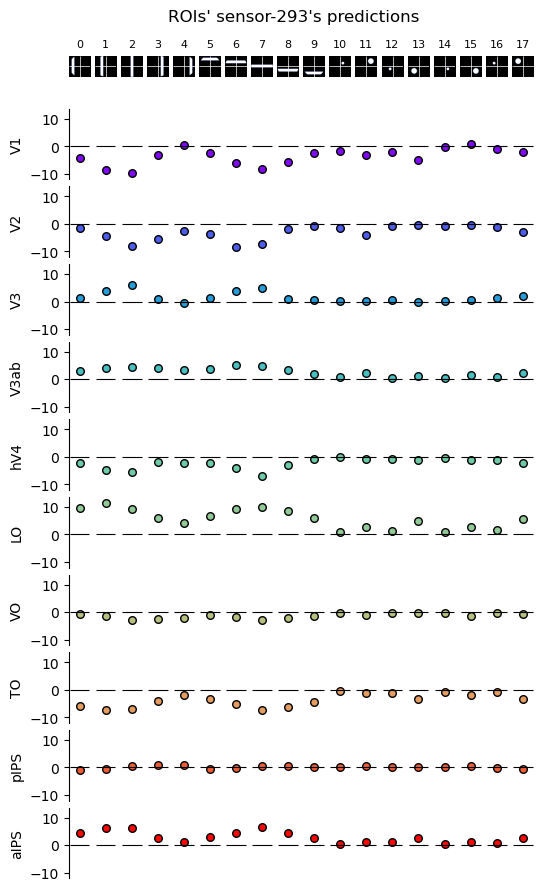

In [55]:
fig_senspreds = visualize.sensor_preds(sensor_predictions=prf.sensor_predictions, design_matrix=design_matrix,
                                       sensor = 293)

### *Visualize sensors' **measured** responses to stimuli*

The created sensor predictions above will be fitted to the measured data.  
The ridge regression used for fitting will use only sub-sets of the measured data for training and testing of the data, but here we can look at the general average response from the example sensor. 

The example sensor below responds most to bar stimuli. It's first peak response is already before 100 ms after stimulus onset (0 ms). 

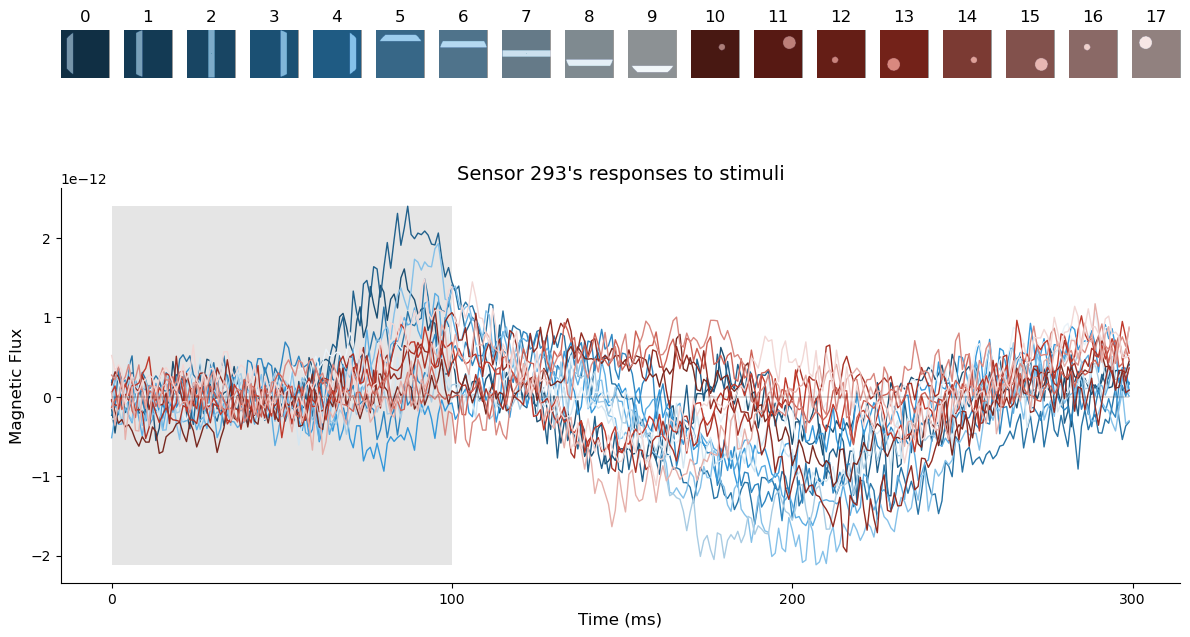

In [56]:
# First, lets average over all trials of a given stimulus for this visualization 
sensor = 293 
avg_all_trials = np.array([np.mean(sensor_data[stim][sensor,:,:],axis=0) for stim in range(len(sensor_data))])

fig_data = visualize.sensor_responses(avg_sensor_data = avg_all_trials, 
                                      design_matrix = design_matrix, sensor = sensor) 

# Step 2: Fit sensor predictions to sensor data 

We fit the predictions to each sample of the sensor data in a cross-validated ridge regression which punishes correlated predictions.  
Finding the optimal regularization parameters is difficult, so we implement the `fracridge` toolbox (Rokem & Kay, 2020, GigaScience) to find the optimal regularization parameters (see https://nrdg.github.io/fracridge/ for a detailed explanation). 
`nr_sets` determines the amount of training vs test data that used for the ridge regression. One of the `nr_sets` is left out for last independent testing of the model performance with the regularization parameters found of the training datasets. The optimal regularization parameters are determined in a k-fold procedure. So if `nr_sets` is 4, then 1 datast is left out for independent testing, and the other 3 are used in the k-fold procedure. The k-fold procedure tests the fractions (`fracs`) or also called 'gamma' values that determine the amount of regularization.  
The training/test datasets, which are randomly averaged `nr_sets` of the sensor data's trials per stimulus are created by the `Fitting` class.  
The sensors have different viewpoints of the same underlying brain responses and the ROI definitions allow us to test which area explains the signal best at what timepoint. So for both sensor predictions and averaged sensor data, we each sensors and stimulus response in the fitting process (fitting arrays of shape (sensors x stimuli,)). 

For more details on the procedure see Eickhoff et al. (2025), *bioRxiv*. 


**In this step, we need:** 
- output from previous step (sensor_predictions)
- sensor data 

**Overview output** - the `Fitting` class provides: 
* the optimal regularization parameters (frac (also called *gamma*) value and the belonging *alpha* value) found by the k-fold cross-validation procedure for a given sample 
    > *output*: `Fitting.gammas` of shape `(samples,)` and  `Fitting.alphas` of shape `(samples,)`
* the performance (variance explained) of the full model (all predictors, aka ROIs) in explaining the data at each timepoint 
    > *output*: `Fitting.r2s_full_model` of shape `(samples,)`
* the performance of the individual ROIs in explaining the data and their associated beta values 
    > *output*: `Fitting.r2s_per_roi` of shape `(rois, samples)` and `Fitting.betas_per_roi` of shape `(rois, samples)` 

## Schematic overview 

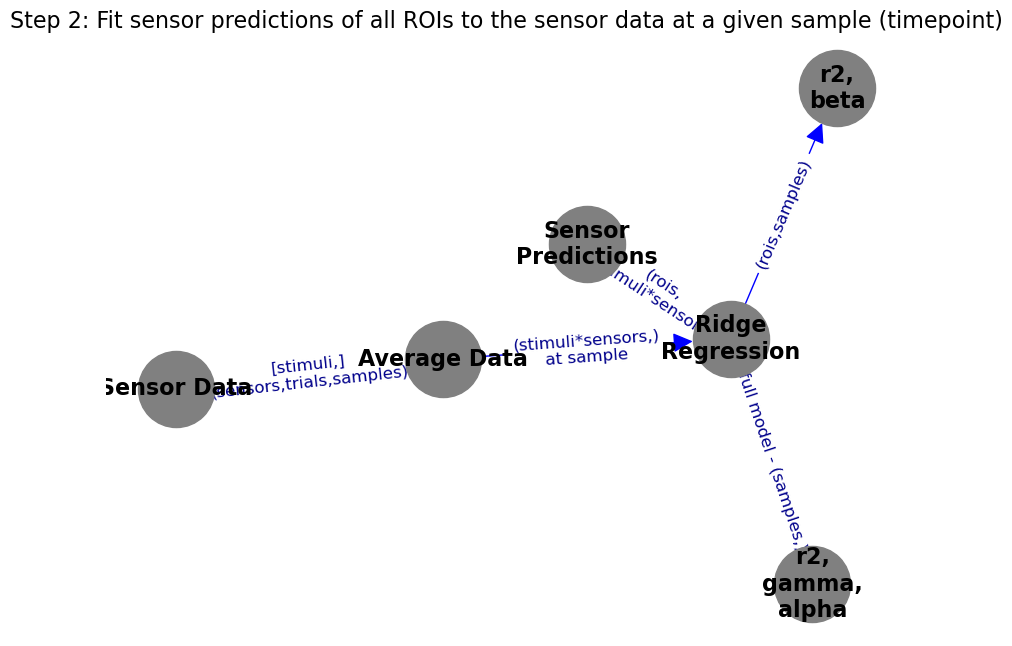

In [69]:
fig_flow2 = visualize.flow_chart_step_2() 

## Perform step 2 

In [70]:
# Settings for CV fitting 
fracs = np.arange(0.0, 1.1, 0.1) # determines the range of factions (gamma ratios) are tested by fracridge 
nr_sets =  4 # number of datasets used by the procedure, nr_sets-1 sets are used for fracridge k-fold procedure (nr_sets should be 4 at least)

# Optional parameters can restrict which parts of the data are used: 
# sample_indices = np.arange(0,200) # to restrict range of sampels fitted 
# stimuli_indices = np.arange(10) # e.g. in the example case to only use bar stimuli 
# sensor_indices = np.arange(306)[::2] # e.g. in the example case to only use magnetometers  
# roi_indices = np.array([0,1,2]) # e.g. in example case to only use V1-3 (not including all 
#                                   possible ROI's as regressors influences the fit, as unexplained data will be attributed to the included regressors)

# we provide n_set_inds_per_stim to make 'random' averaging of datasets repeatably - leaving out 
#   this variable for the class to create a new random set of indices for averaging 
#   the indices can be saved later by saving Fitting.n_set_inds_per_stim 


full_fit = Fitting(sensor_data, prf.sensor_predictions, 
                   nr_sets=nr_sets, fracs=fracs,
                   n_set_inds_per_stim=n_set_inds_per_stim) 
full_fit.run()

1: Predictions reshaped to: (10, 5508) (rois, stimuli*sensors)
2: Using 4-sets of indices for data averaging.
3: Data averaging for 4 sets completed.
4: Using 3-fold CV to define ridge parameters on training set...
|-     K-fold indices prepared.
5: Fitting 10 rois, 300 samples and 5508 datapoints (18 stimuli * 306 sensors) ...
|-     Fitting process completed.


## Visualize

### *Visualize optimized regularization parameters and full model performance*
Full model performance nicely aligns with the observed sensor's time courses. We observe an early peak before 100 ms after stimulus onset, and a second more prolonged one after 200 ms.   
Regularization is high (low gamma / high alpha) when no signal is present yet (before ~50 ms), and low after. 

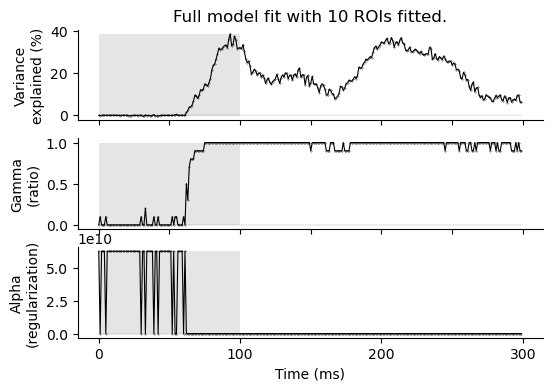

In [72]:
fig_fm = visualize.full_model_fit_and_reg(full_fit)

### *Visualize ROI's fitting results*
Importantly, this pipeline allows us to view the contributions of the regions of interest in explaining the observed brain signals.   
For the stimulus we used (low level checkerboards), most variance explained was observed for V1. We find a trend of increasing latencies of activation windows across the visual hierarchy. 



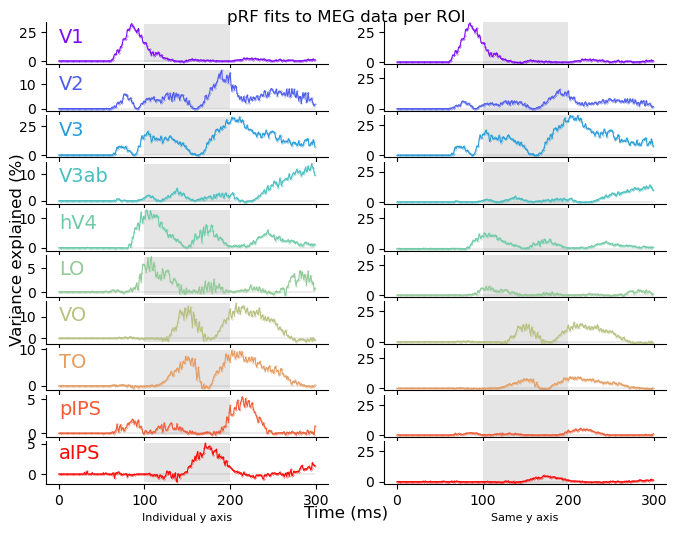

In [74]:
fig_roifits = visualize.roi_fits(full_fit)

# *Done!*
We've characterized the responses along the visual hierarhcy using pRF models and MEG data.

# Optional: Additional testing (position scrambling example)
The pipeline can be verified in many ways (see Eickhoff et al. (2024), *Imaging Neuroscience*, and Eickhoff et al. (2025), *bioRxiv* for multiple examples).   
Here we show an example of testing whether it is truly the pRF parameters that explain the signals. We will scramble the estimated parameters (here the pRF's **position**) and see whether the variance explained is affected. If the parameters matter, then variance explained should go down. 
Systematically (instead of random) scrambling of the pRF positions provides the advantange that we know exactly what we do to the data, but random scrambling could be applied as well. 



## Create new (scrambled) pRF models 
To save computation power here we will rotate the pRF positions clockwise and counterclockwise by 90 degrees, and also fit the originally estimated pRF positions (rotation angle 0) for comparison. 

In [ ]:
# Angles we want to apply to the pRF positions 
angles = [-90, 0, 90]

# For each angle, create a new set of pRF models, predictions and fit them to the sensor data. 
rotated_prfs = [] 
rotated_fits = [] 
for angle in angles: 
    print(f"Getting data and fits for angle {angle}...")
    
    # a) Get systematically shifted parameter set 
    shifted_prf_params = GaussianModel.perturb_prf_angle(prf_parameters, angle=angle)
    # and create its prfs and predictions
    cur_prf = pRFs(prf_parameters = shifted_prf_params, 
                    model_class=GaussianModel, model_kwargs={'nr_pix': nr_pix, 'max_ecc': max_ecc}, 
                    mask=mask, verbose=False)
    cur_prf.create_sensor_predictions(gain_matrix=gain_matrix, 
                              design_matrix=design_matrix,
                              roi_masks=roi_masks)           
    rotated_prfs.append(cur_prf)
    
    # b) Re-fit 
    cur_fit = Fitting(sensor_data, cur_prf.sensor_predictions, 
                        nr_sets=nr_sets, fracs=fracs,
                        n_set_inds_per_stim=n_set_inds_per_stim) 
    cur_fit.run()
    rotated_fits.append(cur_fit) 
print("Done with all angles.") # (took 4 min for me)

Getting data and fits for angle -90...
1: Predictions reshaped to: (10, 5508) (rois, stimuli*sensors)
2: Using 4-sets of indices for data averaging.
3: Data averaging for 4 sets completed.
4: Using 3-fold CV to define ridge parameters on training set...
|-     K-fold indices prepared.
5: Fitting 10 rois, 300 samples and 5508 datapoints (18 stimuli * 306 sensors) ...
|-     Fitting process completed.
Getting data and fits for angle 0...
1: Predictions reshaped to: (10, 5508) (rois, stimuli*sensors)
2: Using 4-sets of indices for data averaging.
3: Data averaging for 4 sets completed.
4: Using 3-fold CV to define ridge parameters on training set...
|-     K-fold indices prepared.
5: Fitting 10 rois, 300 samples and 5508 datapoints (18 stimuli * 306 sensors) ...
|-     Fitting process completed.
Getting data and fits for angle 90...
1: Predictions reshaped to: (10, 5508) (rois, stimuli*sensors)
2: Using 4-sets of indices for data averaging.
3: Data averaging for 4 sets completed.
4: Using

## Visualize 

### *Visualize full model perforamnce - comparing original pRF position to rotated positions*
Variance explained drops when pRF position is moved away from their originally estimated position. Notably, that reduction is not the same across time! Although not quantified here, reductions seems strongest during the earliest peak response (when pRF positions are expected to be localized to the input stream), while the exact pRF parameters seem to matter less during later respones. We can hypothesize that later intime, the signal has reached higher order regions which are more position insentive. 

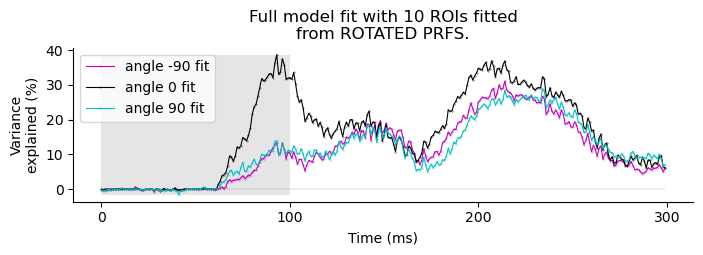

In [77]:
fig_rot_fm = visualize.full_model_rotated_prfs(rotated_fits, angles)

### *Visualize ROI's performance - for the original and scrambled pRF positions*
V1 with very small, local pRFs is strongly affected by rotating the pRF positions away, while higher order areas (such as aIPS) with larger receptive fields is not affected as much - they are more stimulus invariant. 

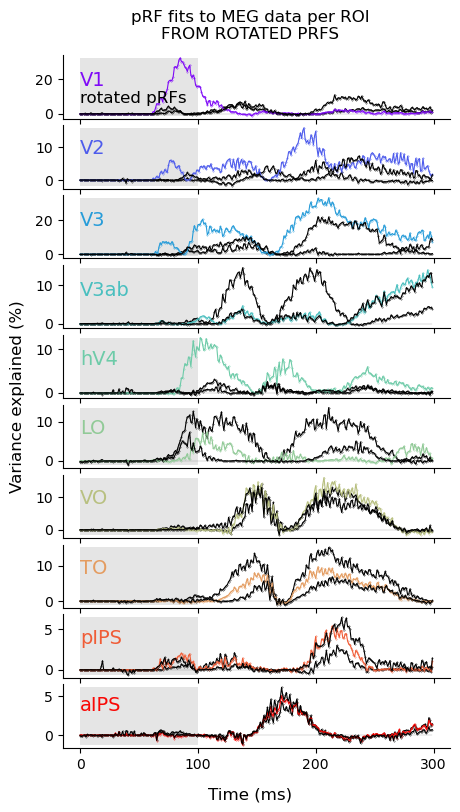

In [79]:
fig_rotrois = visualize.rois_rotated_prffits(rotated_fits, angles)

# Done! 
## Summary 
This notebook completes the full spatiotemporal modeling pipeline of the `pRFtime` package, and you now have: 
- estimated full model fits over time 
- ROI-specific contributions to the measured signal over time 
- a visualization of how the modeled visual hierarchy unfolds over time 
- that pRF positions matter, especially early in time when signals are dominated by small localized pRFs 

This pipeline can be used for your own datasets, or exploring additional (validation) analysis and further quantifications.